In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [2]:
from fastai.vision.all import *


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 


#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [3]:
path = Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training')

In [4]:
fns = get_image_files(path)
fns

(#3087) [Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_1462.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_4424.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_5215.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_5539.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_6127.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_100_0_6639.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101_0_1029.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101_0_1757.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101_0_5683.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101_0_6128.jpg'),Path('Teeth Data one/Teeth DataSet/Teeth_Dataset/Training/CaS/a_101_0_6350.jpg'),Path('Teeth Data one/Teeth

In [5]:
## This is a data loader

## parent_label -> simply gets the name of the folder a file is in

Teeth = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct=0.2, seed=42),
     get_y = parent_label,
     item_tfms = Resize(128)  ## by default it crops
)

In [6]:
dls = Teeth.dataloaders(path)

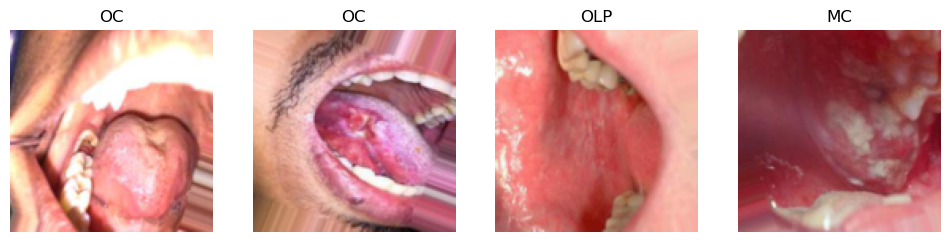

In [7]:
## by defaullt it will give the model batches of 64 for training and testing

## to view

dls.valid.show_batch(max_n=4, nrows=1)

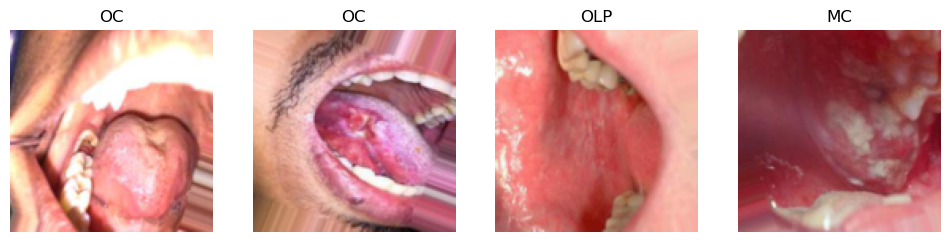

In [8]:
## instead of cropping

## we can pad the images

Teeth = Teeth.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))

dls = Teeth.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

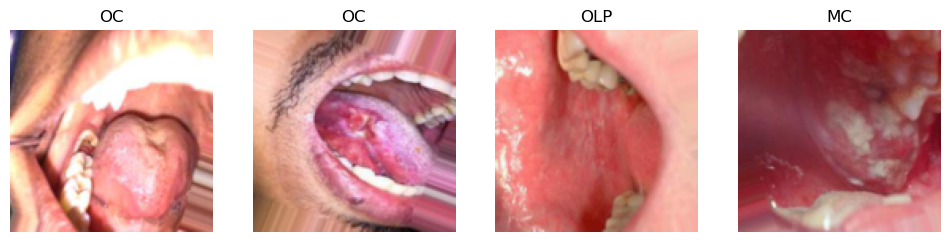

In [9]:
## or we can squish them

Teeth = Teeth.new(item_tfms=Resize(128, ResizeMethod.Squish))

dls = Teeth.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

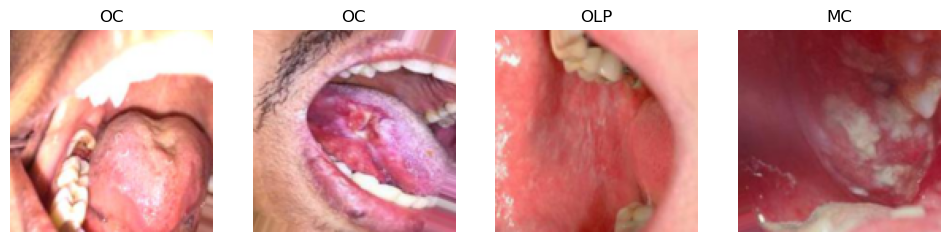

In [10]:
## random cropping of an image is considered better

Teeth = Teeth.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = Teeth.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

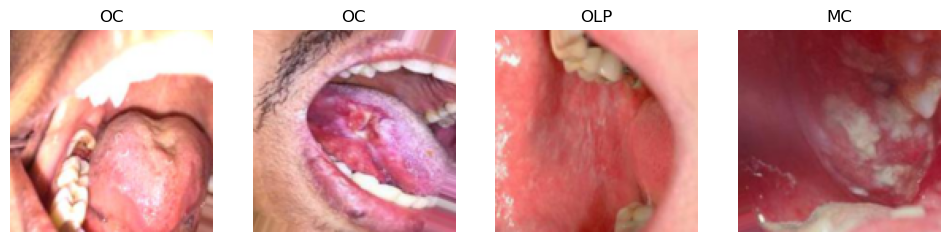

In [11]:
Teeth = Teeth.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))

dls = Teeth.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

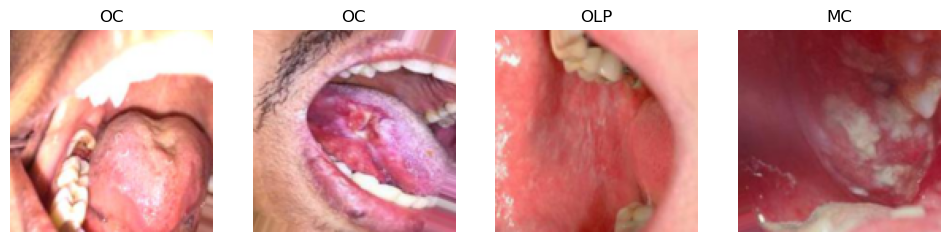

In [12]:
Teeth = Teeth.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = Teeth.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

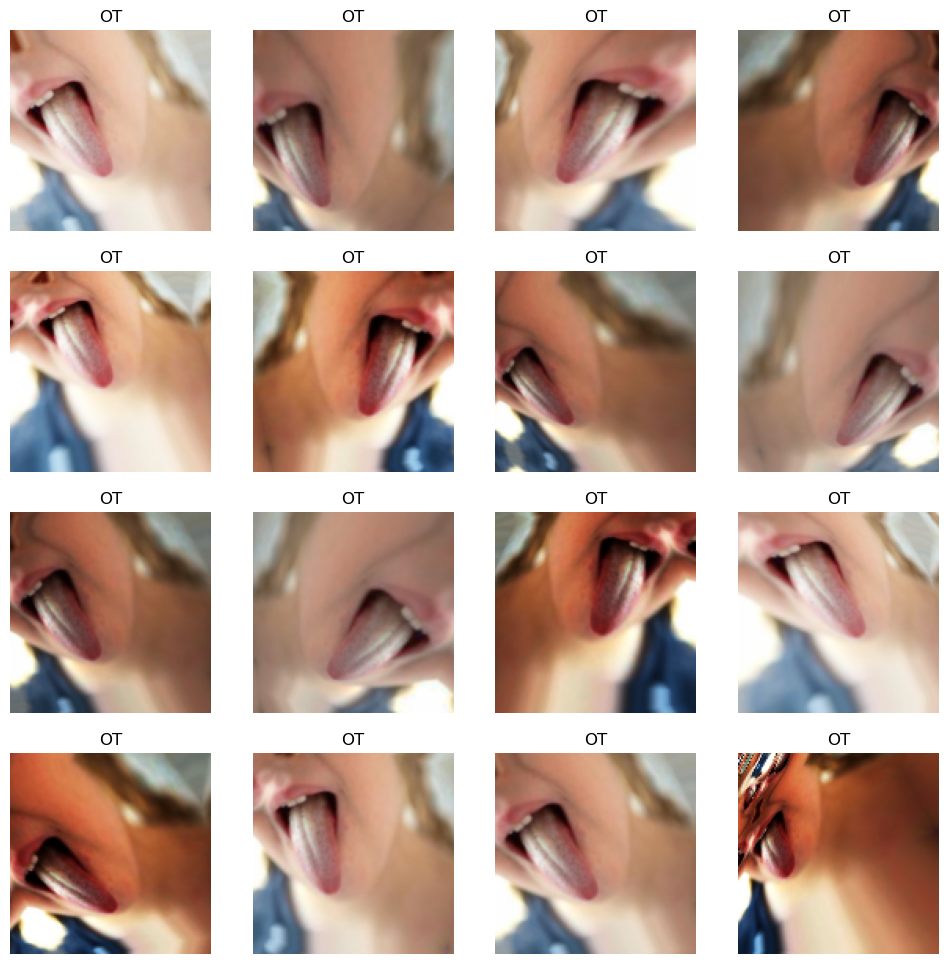

In [13]:
## data augmentation: rotation, flipping, perspective warping, contrast and brightness changes
## via GPU intensive batch_transforms

Teeth = Teeth.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = Teeth.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [14]:
## now fine tune cnn_learner with our data

Teeth = Teeth.new(
     item_tfms=RandomResizedCrop(224, min_scale=0.5),
     batch_tfms=aug_transforms()
)

dls = Teeth.dataloaders(  path  )

learn = cnn_learner(dls, resnet18, metrics=error_rate)    ## metrics=batch_accuracy, metrics=accuracy

learn.fine_tune(10)

C:\Users\Dell\anaconda3\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


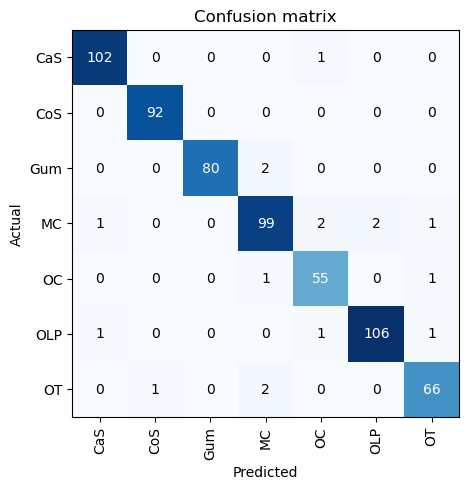

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

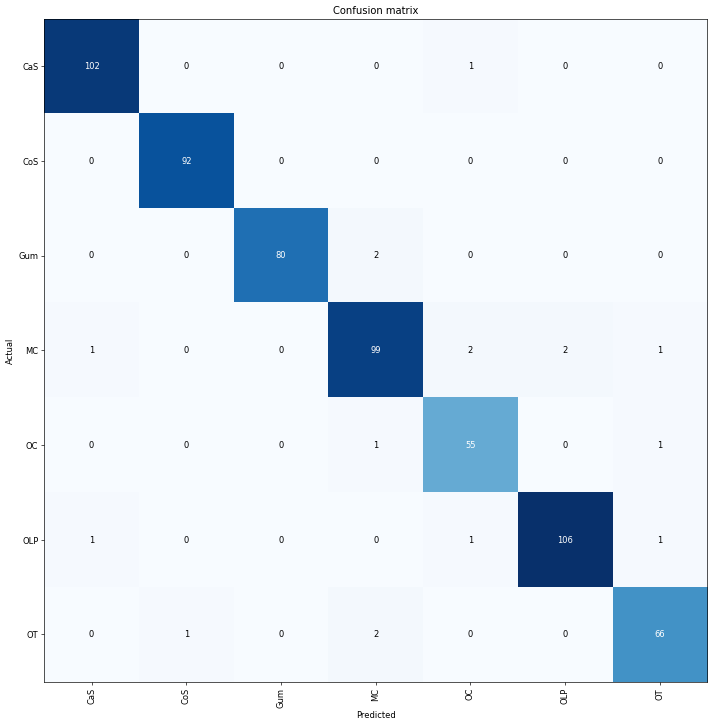

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
preds, y, losses = learn.get_preds(with_loss=True)

In [18]:
preds.shape


y_pred = torch.argmax(preds, dim=1)
y_pred.shape

torch.Size([617])

In [19]:
y.shape

torch.Size([617])

In [20]:
y_np       = y.numpy()
y_pred_np = y_pred.numpy()

accuracy = accuracy_score(y_np, y_pred_np)

f1 = f1_score(y_np, y_pred_np, average='weighted')

print(accuracy)
print(f1)

0.9724473257698542
0.9724659497757409


In [21]:
learn.dls.vocab

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

In [22]:
print(classification_report(y_np, y_pred_np))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       103
           1       0.99      1.00      0.99        92
           2       1.00      0.98      0.99        82
           3       0.95      0.94      0.95       105
           4       0.93      0.96      0.95        57
           5       0.98      0.97      0.98       109
           6       0.96      0.96      0.96        69

    accuracy                           0.97       617
   macro avg       0.97      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617



In [23]:
print(classification_report(y_np, y_pred_np, target_names=learn.dls.vocab))

              precision    recall  f1-score   support

         CaS       0.98      0.99      0.99       103
         CoS       0.99      1.00      0.99        92
         Gum       1.00      0.98      0.99        82
          MC       0.95      0.94      0.95       105
          OC       0.93      0.96      0.95        57
         OLP       0.98      0.97      0.98       109
          OT       0.96      0.96      0.96        69

    accuracy                           0.97       617
   macro avg       0.97      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617



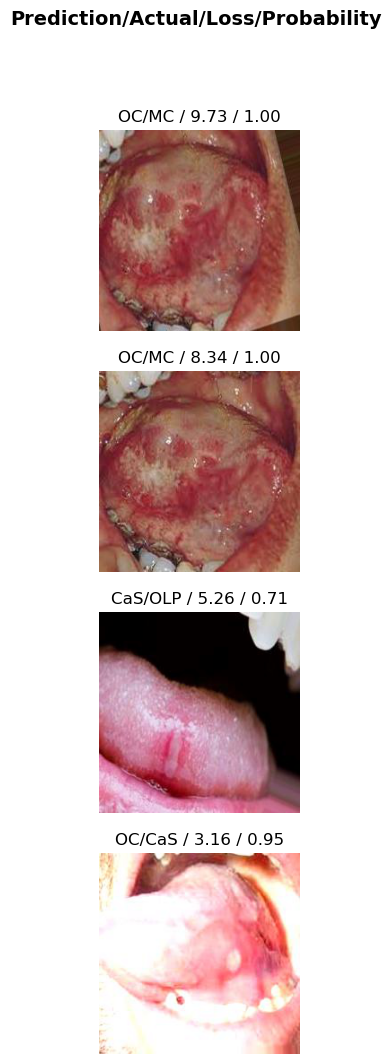

In [24]:
## plot_top_losses shows us the images with the highest loss in our dataset


interp.plot_top_losses(4, nrows=4)

In [25]:
## will save an export file called export.pkl to save the model


learn.export("CIFAR10ModelLabels.pkl")

In [26]:
## load_model from file


learn_inf = load_learner('CIFAR10ModelLabels.pkl')

In [27]:
img = 'Teeth Data one/Teeth DataSet/Teeth_Dataset/Testing/CaS/a_100.jpg'


is_plane, _, probs = learn.predict(img)
print(is_plane)
print(probs)

CaS
tensor([    0.9890,     0.0097,     0.0011,     0.0000,     0.0000,     0.0001,
            0.0001])


In [28]:
is_plane, _, probs = learn_inf.predict(img)
print(is_plane)
print(probs)

CaS
tensor([    0.9890,     0.0097,     0.0011,     0.0000,     0.0000,     0.0001,
            0.0001])


In [29]:
learn_inf.dls.vocab

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

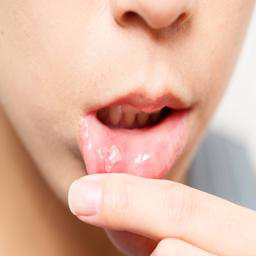

In [30]:
im = Image.open(img)
im.thumbnail((256,256))
im

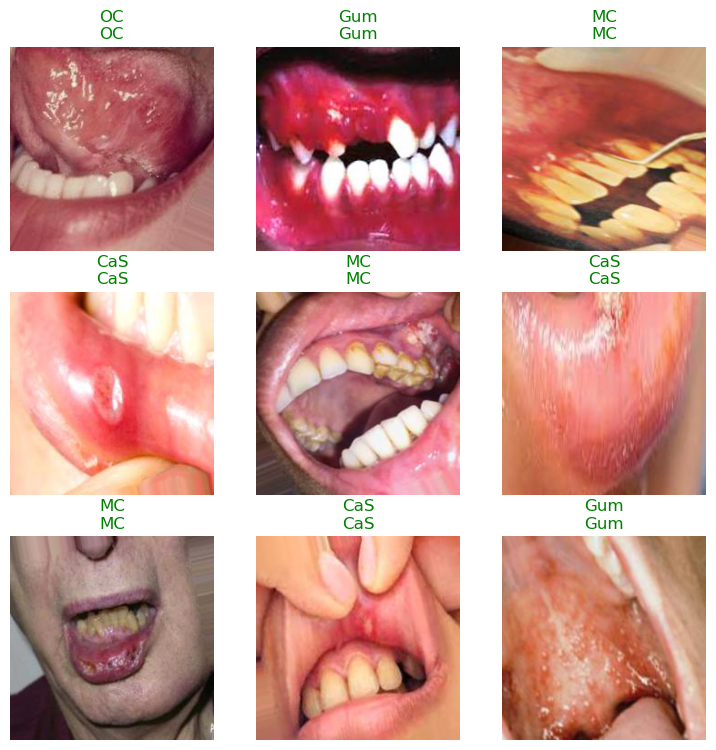

In [66]:
learn.show_results()

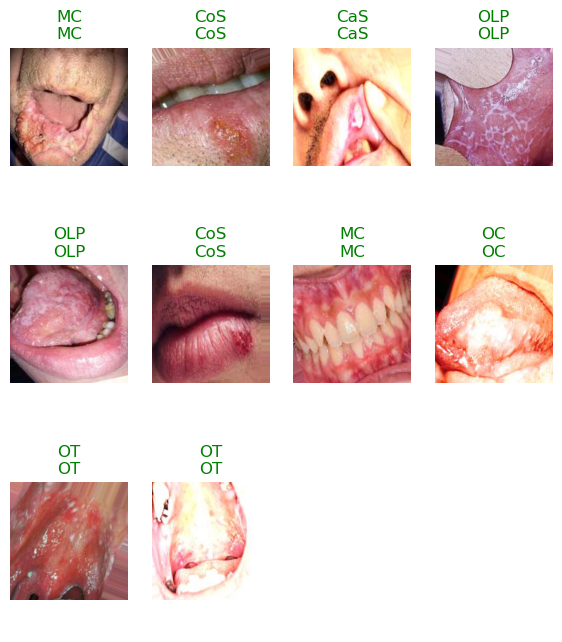

In [68]:
learn.show_results(max_n=10, figsize=(7, 8))